# Artificial Neural Networks and Deep Learning Challenge 1: Image Classification of a RGB 96x96 blood cells dataset
In this assignment, we built a model to classify 96x96 RGB images of blood cells. These images are categorized into eight classes, each representing a particular cell state. This is a multi-class classification problem, so the goal is to assign the correct class label to each RGB image.

cleaned_no_duplicates.npz is the train dataset, already cleared from outliers and duplicates.

---
## How to run with this notebook
Follow these steps:
- If in Colab:
0. This notebook is expected to be opened and executed from a Google Drive folder called `ANNDL-challenge1`, which should also contain the `cleaned_no_duplicates.npz` file
1. Create a folder named `ANNDL-challenge1` in your Google Drive.
2. Upload the `cleaned_no_duplicates.npz` file to this folder.
3. Upload and run this notebook.

- If in Kaggle:
0. This notebook is expected to be executed from Kaggle
1. Upload the `cleaned_no_duplicates.npz` file to Kaggle.
2. Run this notebook.

## Settings Variables

In [1]:
# To run the code alternatively in Colab or Kaggle
IS_COLAB = True

# Seed for Randomness
SEED = 42

# Name of the file for plotting validation/test accuracy and loss of all the models trained in the past
METADATA_FILE = 'metadata.pkl'

# Set Dataset path
if IS_COLAB :
    DATA_FILE = 'cleaned_no_duplicates.npz'
else:
    # (Kaggle) Dataset file path
    DATA_FILE = '/kaggle/input/cleaned-no-duplicates-cells/cleaned_no_duplicates.npz'

## Model Parameters

In [2]:
# Ratio of validation set wrt the whole dataset
VALIDATION_SPLIT = 0.1

# Batch size for training
BATCH_SIZE = 64

## 🌐 Connect Colab to Google Drive

In [3]:
if IS_COLAB:
    from google.colab import drive

    drive.mount('/gdrive')
    %cd /gdrive/My Drive/ANNDL-challenge1

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/ANNDL-challenge1


## ⚙️ Import Libraries

In [4]:
!pip install keras-cv

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras.applications.mobilenet import preprocess_input
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import keras_cv

import os
import shutil
import pickle
from collections import Counter

np.random.seed(SEED)
tf.random.set_seed(SEED)
tf.compat.v1.set_random_seed(SEED)

plt.rc('font', size=14)

## Load Metadata to Store Histories

In [6]:
if os.path.exists(METADATA_FILE):
    with open(METADATA_FILE, 'rb') as f:
        metadata = pickle.load(f)
else:
    metadata = {}

## ⏳ Load the Data

In [7]:
with np.load(DATA_FILE) as data:
    X = data['images']
    y = data['labels']

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

# Define a mapping of labels to their corresponding names
labels = {0:'Basophil', 1:'Eosinophil', 2:'Erythroblast', 3:'Granulocytes',
          4:'Lymphocyte', 5:'Monocyte', 6:'Neutrophil', 7:'Platelet'}

unique_labels = np.unique(y)

Shape of X: (11951, 96, 96, 3)
Shape of y: (11951, 1)


## Visualize Distribution of Class Labels in the Dataset
Show the distribution of Class Labels in the Dataset and first image for each class

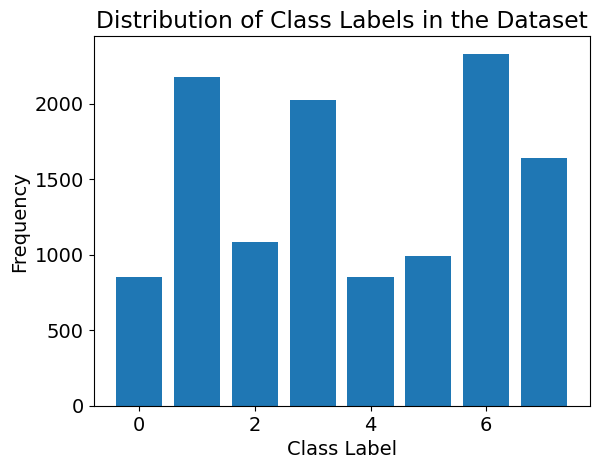

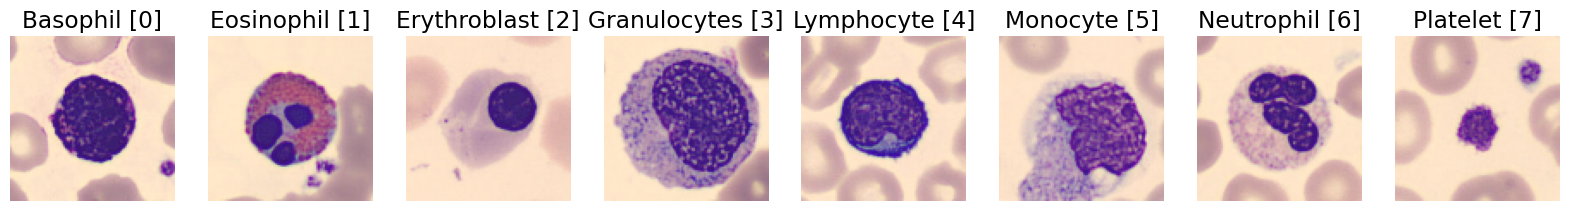

In [8]:
# Distribuzione delle etichette
labels_count = Counter(y.flatten())
plt.bar(labels_count.keys(), labels_count.values())
plt.xlabel("Class Label")
plt.ylabel("Frequency")
plt.title("Distribution of Class Labels in the Dataset")
plt.show()

fig, axes = plt.subplots(1, len(unique_labels), figsize=(20, 15))

for i, label in enumerate(unique_labels):
    idx = np.where(y == label)[0][0]  # Trova l'indice della prima immagine con questa etichetta
    axes[i].imshow(X[idx])
    axes[i].set_title(labels[label] + ' [' + str(label) + ']')
    axes[i].axis('off')

plt.show()

## Apply Class Weights
for compensating the dataset imbalancement during training

In [9]:
# Calculate Class Weights Based on the class distributions
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y.ravel())
class_weights_dict = dict(enumerate(class_weights))
print("Class weights:", class_weights_dict)

Class weights: {0: 1.7575, 1: 0.6855782469022488, 2: 1.3768433179723503, 3: 0.7384453781512605, 4: 1.7595700824499412, 5: 1.505922379032258, 6: 0.6411480686695279, 7: 0.9092361533779671}


## Data Preprocessing
Split the dataset

In [10]:
# convert all pixels to the range [0, 1]
X = (X / 255).astype('float32')

# Convert labels to categorical format using one-hot encoding
y = tfk.utils.to_categorical(y)

X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.1, random_state=SEED)

# Print the shapes of the resulting datasets
print("Training Data Shape:", X_train.shape)
print("Training Label Shape:", y_train.shape)
print("Validation Data Shape:", X_val.shape)
print("Validation Label Shape:", y_val.shape)

Training Data Shape: (10755, 96, 96, 3)
Training Label Shape: (10755, 8)
Validation Data Shape: (1196, 96, 96, 3)
Validation Label Shape: (1196, 8)


Apply Augmentation (RandAugment and Augmix) and print some agumented images

In [11]:
rand_augment = keras_cv.layers.RandAugment(
    value_range=(0, 1),
    augmentations_per_image=2,
    magnitude=0.1
)

augmix = keras_cv.layers.AugMix(
    value_range=(0, 1),
    severity=0.1,
    num_chains=2,
    chain_depth=[1, 3],
)

train_dataset_augmented = (
    tf.data.Dataset.from_tensor_slices((X_train, y_train))
    .shuffle(BATCH_SIZE * 100)
    .batch(BATCH_SIZE)
    .map(
        lambda x, y: (rand_augment(augmix(x)), y),
        num_parallel_calls=tf.data.AUTOTUNE,
    )
    .prefetch(tf.data.AUTOTUNE)
    .unbatch()
)

In [12]:
X_train_augmented = []
y_train_augmented = []

for element in train_dataset_augmented.as_numpy_iterator():
    X_train_augmented.append(element[0])
    y_train_augmented.append(element[1])

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

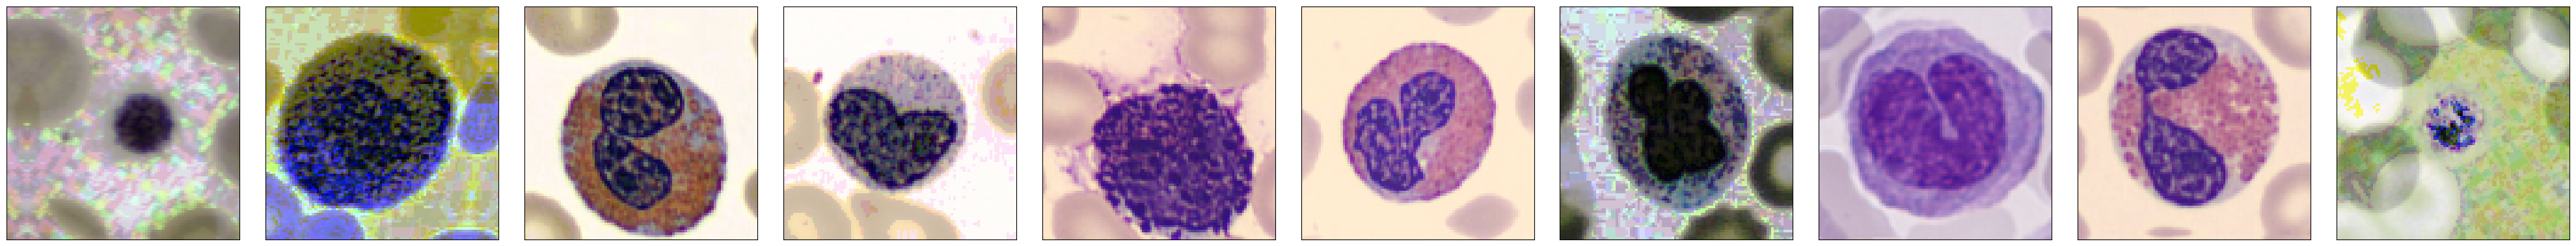

In [14]:
img_to_show = 10
fig, axes = plt.subplots(1, img_to_show, figsize=(4 * img_to_show, 4))

# Display some random images for each class
for i in range(img_to_show):
    ax = axes[i]
    ax.imshow(X_train_augmented[i])
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

## 🛠️ Build the Model

In [15]:
# Input shape for the model
input_shape = X_train_augmented.shape[1:]

# Output shape for the model
output_shape = y_train_augmented.shape[1]

print("Input Shape:", input_shape)
print("Output Shape:", output_shape)

Input Shape: (96, 96, 3)
Output Shape: 8


Apply an augmentation layer

In [16]:
augmentation_layer = tf.keras.Sequential([
    tfkl.RandomFlip("horizontal_and_vertical"),
    tfkl.RandomTranslation(0.2,0.2),
    tfkl.RandomRotation(0.35),
    tfkl.RandomZoom(0.2),
], name='augmentation')

In [17]:
# Number of training EPOCHS
EPOCHS = 1000

# Batch size for training
BATCH_SIZE = 64

# Learning rate: step size for updating the model's weights
LEARNING_RATE = 0.001

# Rate of the Dropout layers
DROPOUT_RATE=0.3

# L2 regularization
L2_LAMBDA = 0.001

In [18]:
def build_model(
    input_shape=input_shape,
    output_shape=output_shape,
    learning_rate=LEARNING_RATE,
    seed=SEED,
    l2_lambda=L2_LAMBDA
):
    initializer = tfk.initializers.HeUniform(seed)
    regulariser = tfk.regularizers.l2(l2_lambda)

    # Build the neural network layer by layer
    inputs = tfkl.Input(shape=input_shape, name='input')

    x = augmentation_layer(inputs)

    x = tfkl.Conv2D(filters=32, kernel_size=3, padding='same', name='conv1')(x)
    x = tfkl.Activation('relu', name='act1')(x)
    x = tfkl.MaxPooling2D(pool_size=2, name='mp1')(x)

    x = tfkl.Conv2D(filters=32, kernel_size=3, padding='same', name='conv2')(x)
    x = tfkl.Activation('relu', name='act2')(x)
    x = tfkl.MaxPooling2D(pool_size=2, name='mp2')(x)

    x = tfkl.Conv2D(filters=64, kernel_size=3, padding='same', name='conv3')(x)
    x = tfkl.Activation('relu', name='act3')(x)
    x = tfkl.MaxPooling2D(pool_size=2, name='mp3')(x)

    x = tfkl.Conv2D(filters=64, kernel_size=3, padding='same', name='conv4')(x)
    x = tfkl.Activation('relu', name='act4')(x)
    x = tfkl.MaxPooling2D(pool_size=2, name='mp4')(x)

    x = tfkl.Flatten(name='flatten')(x)
    x = tfkl.Dropout(DROPOUT_RATE)(x)

    x = tfkl.Dense(units=1024, kernel_initializer=initializer, kernel_regularizer=regulariser, name='dense1')(x)
    x = tfkl.Dropout(DROPOUT_RATE)(x)
    x = tfkl.Activation('relu', name='actdense1')(x)

    x = tfkl.Dense(units=1024, kernel_initializer=initializer, kernel_regularizer=regulariser, name='dense2')(x)
    x = tfkl.Dropout(DROPOUT_RATE)(x)
    x = tfkl.Activation('relu', name='actdense2')(x)

    x = tfkl.Dense(units=output_shape, kernel_regularizer=regulariser, name='output')(x)
    outputs = tfkl.Activation('softmax', name='softmax')(x)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=inputs, outputs=outputs, name='CNN')

    # Compile the model
    loss = tfk.losses.CategoricalCrossentropy()
    optimizer = tfk.optimizers.Adam(learning_rate)
    metrics = ['accuracy']
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

    # Return the model
    return model

In [19]:
model = build_model()

# Display a summary of the model architecture
model.summary(expand_nested=True, show_trainable=True)

# Plot the model architecture
# tfk.utils.plot_model(model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

Model: "CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape                 ┃       Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input (InputLayer)                  │ (None, 96, 96, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ augmentation (Sequential)           │ (None, 96, 96, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ random_flip (RandomFlip)       │ (None, 96, 96, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ random_translation_2           │ (None, 96, 96, 3)            │             0 │    -    │
│ (RandomTranslation)                 │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ random_rotation                │ (None, 96, 96, 3)            │             0 │    -    │
│ (RandomRotation)                    │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ random_zoom (RandomZoom)       │ (None, 96, 96, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv1 (Conv2D)                      │ (None, 96, 96, 32)           │           896 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ act1 (Activation)                   │ (None, 96, 96, 32)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ mp1 (MaxPooling2D)                  │ (None, 48, 48, 32)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv2 (Conv2D)                      │ (None, 48, 48, 32)           │         9,248 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ act2 (Activation)                   │ (None, 48, 48, 32)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ mp2 (MaxPooling2D)                  │ (None, 24, 24, 32)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv3 (Conv2D)                      │ (None, 24, 24, 64)           │        18,496 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ act3 (Activation)                   │ (None, 24, 24, 64)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ mp3 (MaxPooling2D)                  │ (None, 12, 12, 64)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv4 (Conv2D)                      │ (None, 12, 12, 64)           │        36,928 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ act4 (Activation)                   │ (None, 12, 12, 64)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ mp4 (MaxPooling2D)                  │ (None, 6, 6, 64)             │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ flatten (Flatten)    

 Total params: 3,483,688 (13.29 MB)

 Trainable params: 3,483,688 (13.29 MB)

 Non-trainable params: 0 (0.00 B)

## 🛠️ Train and Save the Model

Use early stopping: ensuring the model stops training when validation accuracy stops improving for "patience" epochs, and the weights are restored to the best-performing epoch.

In [20]:
# Define the patience value for early stopping
patience = 20

# Create an EarlyStopping callback
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=patience,
    restore_best_weights=True
)

# Store the callback in a list
callbacks = [early_stopping]

In [21]:
# Change this variable to change the name of the .keras file
MODEL_NAME = 'handcrafted'

# Train the model with early stopping callback
history = model.fit(
    x=X_train_augmented,
    y=y_train_augmented,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    class_weight=class_weights_dict
).history

# Calculate and print the final validation accuracy
final_val_accuracy = round(max(history['val_accuracy'])* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'CNN_'+MODEL_NAME+'_'+str(final_val_accuracy)+'.keras'
model.save(model_filename)

# Delete the model to free up resources
del model

Epoch 1/1000
169/169 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - accuracy: 0.1711 - loss: 3.9409 - val_accuracy: 0.2492 - val_loss: 1.8014
Epoch 2/1000
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.2368 - loss: 1.9005 - val_accuracy: 0.1764 - val_loss: 2.0320
Epoch 3/1000
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.3328 - loss: 1.7344 - val_accuracy: 0.4264 - val_loss: 1.4950
Epoch 4/1000
169/169 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.4274 - loss: 1.6501 - val_accuracy: 0.2692 - val_loss: 2.3074
Epoch 5/1000
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.4722 - loss: 1.5355 - val_accuracy: 0.6212 - val_loss: 0.9896
Epoch 6/1000
169/169 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.5294 - loss: 1.3915 - val_accuracy: 0.6488 - val_loss: 0.8569
Epoch 7/1000
169/169 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.5666 - loss: 1.3082 - val_accuracy: 0.6973 - val_loss: 0.8447
Epoch 8/1000
169/169 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.5841 - loss: 

In [22]:
metadata[MODEL_NAME] = (
    round(history['accuracy'][-1] * 100, 2),
    round(max(history['val_accuracy']) * 100, 2),
    history
)

with open(METADATA_FILE, 'wb') as f:
    pickle.dump(metadata, f)

handcrafted train accuracy: 78.34
handcrafted validation accuracy: 90.05


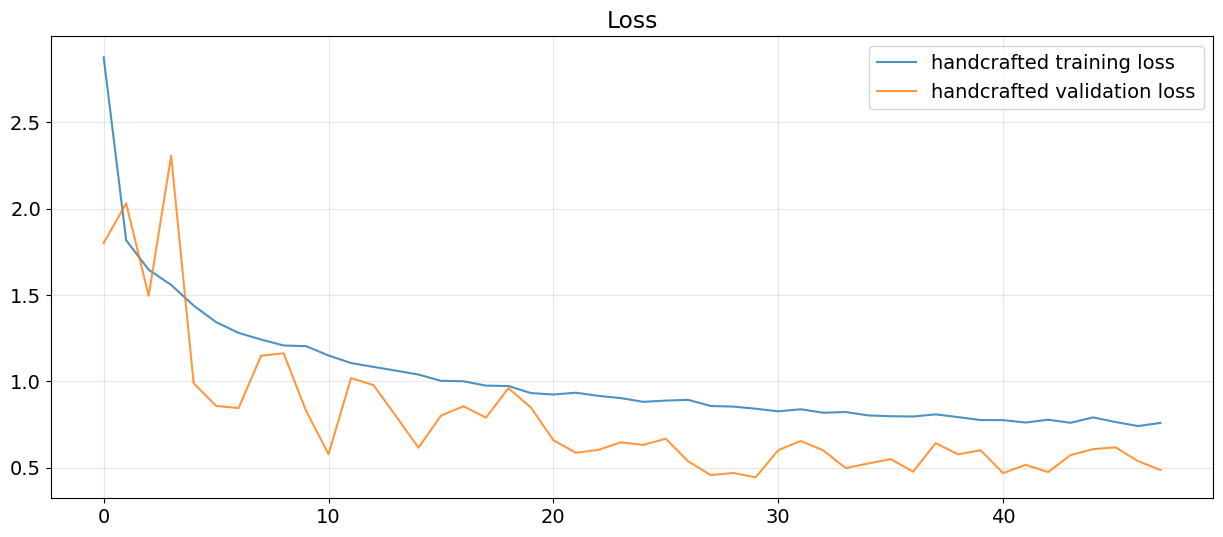

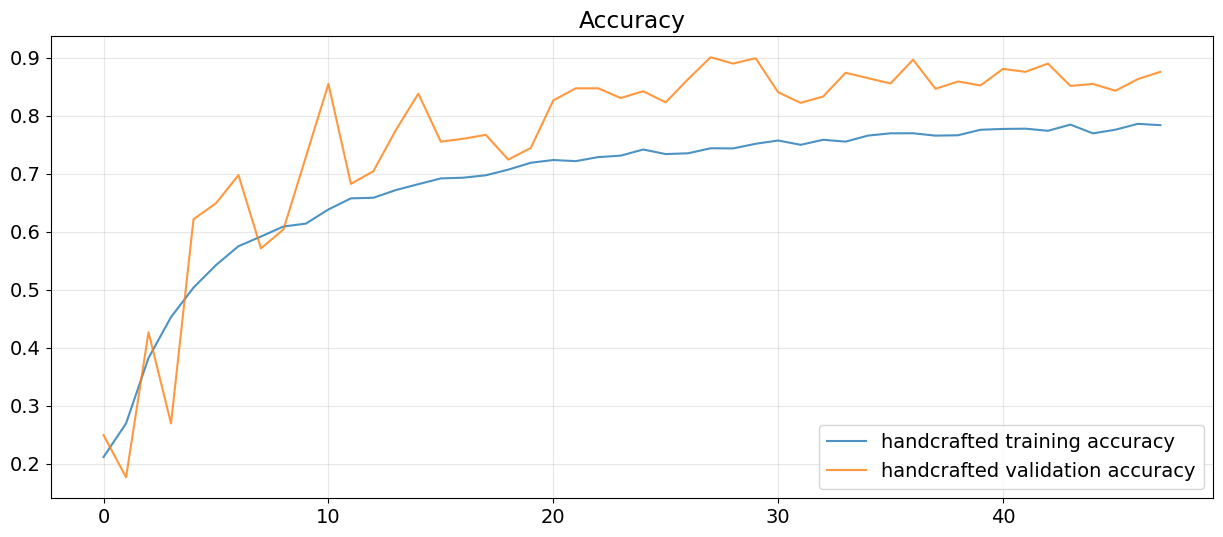

In [23]:
start_epoch = 0

metadata_copy = metadata.copy()

for name, (acc, val_acc, _) in metadata_copy.items():
    print(name + " train accuracy:", acc)
    print(name + " validation accuracy:", val_acc)

# Plot training and validation loss
plt.figure(figsize=(15, 6))
for name, (_, _, saved_history) in metadata_copy.items():
    plt.plot(saved_history['loss'][start_epoch:], label=name+' training loss', alpha=.8)
    plt.plot(saved_history['val_loss'][start_epoch:], label=name+' validation loss', alpha=.8)
plt.title('Loss')
plt.legend()
plt.grid(alpha=.3)

# Plot training and validation accuracy
plt.figure(figsize=(15, 6))
for name, (_, _, saved_history) in metadata_copy.items():
    plt.plot(saved_history['accuracy'][start_epoch:], label=name+' training accuracy', alpha=.8)
    plt.plot(saved_history['val_accuracy'][start_epoch:], label=name+' validation accuracy', alpha=.8)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)

plt.show()

## Confusion Matrixes
Here we perform a strong augmentation on the validation set to see if our model is able to make predictions on distorted images.
This was useful because the accuracy on the augmented validation set was closer to the Codabench test set.
Below we print the accuracy and confusion matrixes of, respectively, both the validation set (without augmentation) and validation set with augmentation

In [26]:
test_augmentation_layer = tf.keras.Sequential([
    tfkl.RandomFlip("horizontal_and_vertical"),
    tfkl.RandomTranslation(0.4,0.4),
    tfkl.RandomRotation(0.4),
    tfkl.RandomZoom(0.4),
    tfkl.RandomBrightness(0.7, value_range=(0,1)),
    tfkl.RandomContrast(0.85),
    tfkl.GaussianNoise(0.15)
], name='augmentation')

X_val_augmented = test_augmentation_layer(X_val)

In [27]:
# Load the saved model
saved_model = tfk.models.load_model(model_filename)

Predictions Shape: (1196, 8)
Accuracy score over the val set: 0.9005
Precision score over the val set: 0.9132
Recall score over the val set: 0.9005
F1 score over the val set: 0.9014


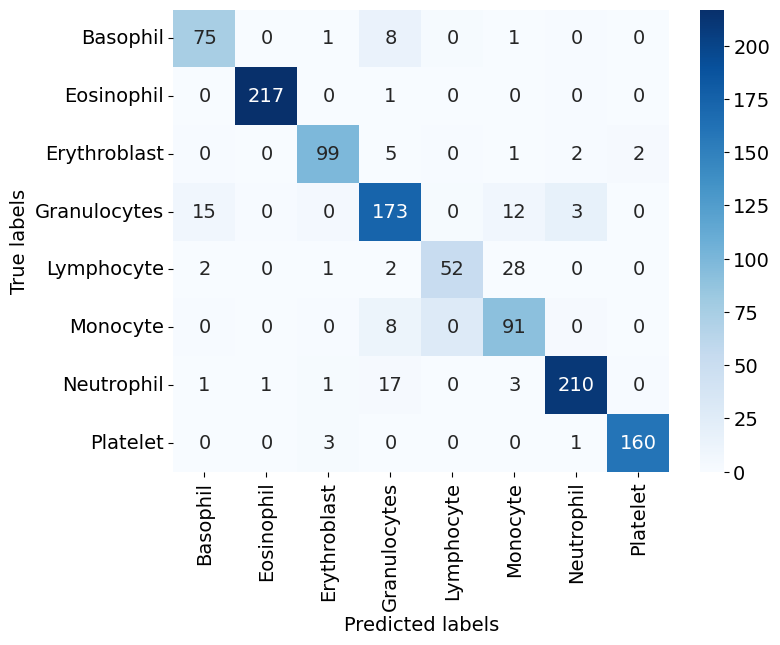

Predictions Shape: (1196, 8)
Accuracy score over the val set: 0.3754
Precision score over the val set: 0.4396
Recall score over the val set: 0.3754
F1 score over the val set: 0.3459


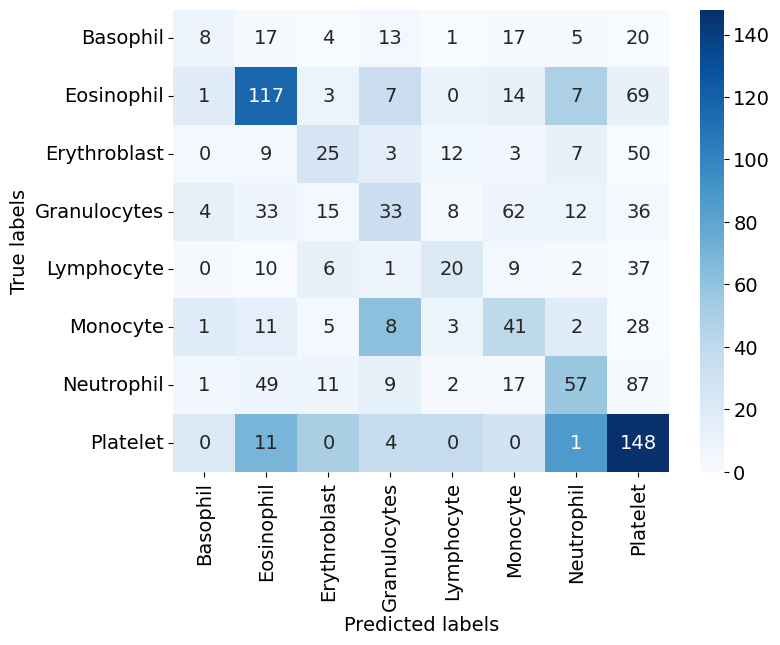

In [28]:
for X_val_i in [X_val, X_val_augmented]:
    # Predict labels for the entire test set
    predictions = saved_model.predict(X_val_i, verbose=0)

    # Display the shape of the predictions
    print("Predictions Shape:", predictions.shape)

    # Convert predictions to class labels
    pred_classes = np.argmax(predictions, axis=-1)

    # Extract ground truth classes
    true_classes = np.argmax(y_val, axis=-1)

    # Calculate and display val set accuracy
    accuracy = accuracy_score(true_classes, pred_classes)
    print(f'Accuracy score over the val set: {round(accuracy, 4)}')

    # Calculate and display val set precision
    precision = precision_score(true_classes, pred_classes, average='weighted')
    print(f'Precision score over the val set: {round(precision, 4)}')

    # Calculate and display val set recall
    recall = recall_score(true_classes, pred_classes, average='weighted')
    print(f'Recall score over the val set: {round(recall, 4)}')

    # Calculate and display val set F1 score
    f1 = f1_score(true_classes, pred_classes, average='weighted')
    print(f'F1 score over the val set: {round(f1, 4)}')

    # Compute the confusion matrix
    cm = confusion_matrix(true_classes, pred_classes)

    # Combine numbers and percentages into a single string for annotation
    annot = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm.T, annot=annot, fmt='', xticklabels=list(labels.values()), yticklabels=list(labels.values()), cmap='Blues')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.show()